Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [2]:
from data_setup import copy_images_to_folders, create_folders, remove_folders, split_data_for_class, split_data
from image_check import imshow
from model import CustomEfficientNetB0, CustomLoss, compute_class_weights, normalize_matrix, print_matrix, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage, process_uncertainties, calculate_variational_ratio_dropout_uncertainties, calculate_mutual_information_mc_dropout, select_desired_metrics

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
# Constants
CSV_PATH = 'data/ISIC_2019_Training_GroundTruth.csv'
IMAGE_FOLDER = 'data/ISIC_2019_Resized'
SORTED_FOLDER = 'data/ISIC_Sorted'
SUBSET_FOLDER = 'data/data_subset'
SAMPLE_LIMIT = None  # None or a number up to 12875
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
SET_BATCH_SIZE = 64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

In [5]:
# Validation for ratios
if TRAIN_RATIO + VAL_RATIO + TEST_RATIO != 1:
    print("Invalid data ratios")
else:
    print("Data ratios are valid")

    # Perform operations
    copy_images_to_folders(CSV_PATH, IMAGE_FOLDER, SORTED_FOLDER)
    print("images split into classes")
    
    remove_folders(os.path.join(SUBSET_FOLDER, 'train'), os.path.join(SUBSET_FOLDER, 'val'), os.path.join(SUBSET_FOLDER, 'test'))
    
    split_data(SORTED_FOLDER, os.path.join(SUBSET_FOLDER, 'train'), os.path.join(SUBSET_FOLDER, 'val'), os.path.join(SUBSET_FOLDER, 'test'), train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO, sample_limit=SAMPLE_LIMIT, seed=6861611)
    print("data split into train, validation and test sets for each class")
    
    # Remove unknown folder as there are no samples
    remove_folders(os.path.join(SUBSET_FOLDER, 'train', 'UNK'), os.path.join(SUBSET_FOLDER, 'val', 'UNK'), os.path.join(SUBSET_FOLDER, 'test', 'UNK'))
    print("UNK folders removed")

Data ratios are valid
images split into classes
data split into train, validation and test sets for each class
UNK folders removed


In [6]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [7]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(SUBSET_FOLDER, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=SET_BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Adjusted way to obtain class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


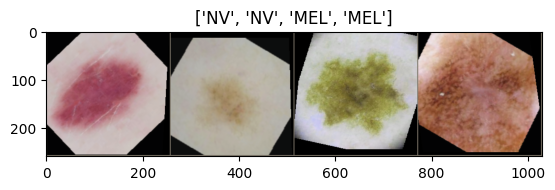

In [8]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

In [9]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [10]:
# Define the class weights matrices and move to device
equal_class_weights_matrix = torch.tensor([
    [0, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 0]
], dtype=torch.float).to(device)

custom_class_weights_matrix = torch.tensor([
    [0,  1,  20,  20,  10, 20,  10, 1],
    [1,  0,  30,  30,  10, 30,  10, 1],
    [10, 10, 0,   1,   10, 1,   10, 10],
    [10, 10, 1,   0,   10, 1,   10, 10],
    [10, 10, 150, 150, 0,  150, 1,  10],
    [10, 10, 1,   1,   10, 0,   10, 10],
    [10, 10, 150, 150, 1,  150, 0,  10],
    [1,  1,  20,  20,  10, 20,  10, 0]
], dtype=torch.float).to(device)

# Divide every value by 150
custom_class_weights_matrix /= 150
print(f"Custom Class Weights / 150:\n{custom_class_weights_matrix}")

save_dirs = ["equal_class_weights_matrix", "custom_class_weights_matrix"]
models = []

Custom Class Weights / 150:
tensor([[0.0000, 0.0067, 0.1333, 0.1333, 0.0667, 0.1333, 0.0667, 0.0067],
        [0.0067, 0.0000, 0.2000, 0.2000, 0.0667, 0.2000, 0.0667, 0.0067],
        [0.0667, 0.0667, 0.0000, 0.0067, 0.0667, 0.0067, 0.0667, 0.0667],
        [0.0667, 0.0667, 0.0067, 0.0000, 0.0667, 0.0067, 0.0667, 0.0667],
        [0.0667, 0.0667, 1.0000, 1.0000, 0.0000, 1.0000, 0.0067, 0.0667],
        [0.0667, 0.0667, 0.0067, 0.0067, 0.0667, 0.0000, 0.0667, 0.0667],
        [0.0667, 0.0667, 1.0000, 1.0000, 0.0067, 1.0000, 0.0000, 0.0667],
        [0.0067, 0.0067, 0.1333, 0.1333, 0.0667, 0.1333, 0.0667, 0.0000]],
       device='cuda:0')


In [11]:
for index, class_weights_matrix in enumerate([equal_class_weights_matrix, custom_class_weights_matrix]):
    print(f"Matrix: {save_dirs[index]}\n")
    
    # Initialize the custom model with dropout
    model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.4)
    
    # Move the model to the specified device (e.g., GPU or CPU)
    model_ft = model_ft.to(device)
    
    # Define the loss function (cross-entropy loss)
    criterion = nn.CrossEntropyLoss()
    
    # Use the Adam optimizer for training
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
    
    # Define a learning rate scheduler to decay the learning rate
    # by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    # Convert targets to tensor and move to device
    targets_tensor = torch.tensor(image_datasets['train'].targets).to(device)
    
    # Compute class weights
    class_weights = compute_class_weights(targets_tensor, len(image_datasets['train'].classes))
    
    # Print class weights
    print("Class Weights:", class_weights)

    #normalized_class_weights_matrix = normalize_matrix(class_weights_matrix)
    
    # Print the normalized matrices
    #print_matrix("Normalized Cost Matrix", normalized_class_weights_matrix)
    
    # Balance the custom class weights matrix using the calculated class weights
    #balanced_class_weights_matrix = normalized_class_weights_matrix * torch.tensor(class_weights, dtype=torch.float).unsqueeze(0).to(device) * 7
    balanced_class_weights_matrix = class_weights_matrix * torch.tensor(class_weights, dtype=torch.float).unsqueeze(0).to(device) * 100
    #balanced_class_weights_matrix = class_weights_matrix.to(device)
    
    print_matrix("Balanced Class Weights Matrix", balanced_class_weights_matrix)

    # Define the loss function using the custom loss
    criterion = CustomLoss(balanced_class_weights_matrix, device).to(device)
    
    model_ft = model_ft.to(device)
    models.append(model_ft)
    
    print()

Matrix: equal_class_weights_matrix

Loaded pretrained weights for efficientnet-b0
Class Weights: [3.652644157409668, 0.9530230760574341, 1.2067184448242188, 13.282342910766602, 0.700101375579834, 0.24587377905845642, 5.0515289306640625, 12.578642845153809]
Balanced Class Weights Matrix:
tensor([[   0.0000,   95.3023,  120.6718, 1328.2343,   70.0101,   24.5874,
          505.1529, 1257.8643],
        [ 365.2644,    0.0000,  120.6718, 1328.2343,   70.0101,   24.5874,
          505.1529, 1257.8643],
        [ 365.2644,   95.3023,    0.0000, 1328.2343,   70.0101,   24.5874,
          505.1529, 1257.8643],
        [ 365.2644,   95.3023,  120.6718,    0.0000,   70.0101,   24.5874,
          505.1529, 1257.8643],
        [ 365.2644,   95.3023,  120.6718, 1328.2343,    0.0000,   24.5874,
          505.1529, 1257.8643],
        [ 365.2644,   95.3023,  120.6718, 1328.2343,   70.0101,    0.0000,
          505.1529, 1257.8643],
        [ 365.2644,   95.3023,  120.6718, 1328.2343,   70.0101,   24.5

In [12]:
for index, model_ft in enumerate(models):
    print(f"Matrix: {save_dirs[index]}\n")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_epoch = 1
    
    train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=5, num_val_mc_samples=10, loss_weight=1, acc_weight=0, num_classes=num_classes, save_dir=save_dirs[index], resume_training=False)
    
    print()

Matrix: equal_class_weights_matrix

Epoch 1/5 - 2024-03-21 09:55:27
----------
Train Loss: 27.9421, Train Acc: 0.0657
Val Loss: 27.7350, Val Acc: 0.0332

Epoch 2/5 - 2024-03-21 09:59:43
----------
Train Loss: 28.1929, Train Acc: 0.0625
Val Loss: 28.4645, Val Acc: 0.0310

Epoch 3/5 - 2024-03-21 10:03:19
----------
Train Loss: 27.7174, Train Acc: 0.0623
Val Loss: 28.7753, Val Acc: 0.0310

Epoch 4/5 - 2024-03-21 10:06:54
----------
Train Loss: 27.1127, Train Acc: 0.0642
Val Loss: 29.8140, Val Acc: 0.0294

Epoch 5/5 - 2024-03-21 10:10:30
----------
Train Loss: 26.8746, Train Acc: 0.0611
Val Loss: 29.6968, Val Acc: 0.0288

Best combined metric: -27.7350
Loss associated with the best combined metric: 27.7350
Accuracy associated with the best combined metric: 0.0332
Epoch associated with the best model: 1


Matrix: custom_class_weights_matrix

Epoch 1/5 - 2024-03-21 10:14:06
----------
Train Loss: 0.7579, Train Acc: 0.4723
Val Loss: 0.9076, Val Acc: 0.4960

Epoch 2/5 - 2024-03-21 10:17:42
---

Matrix: equal_class_weights_matrix



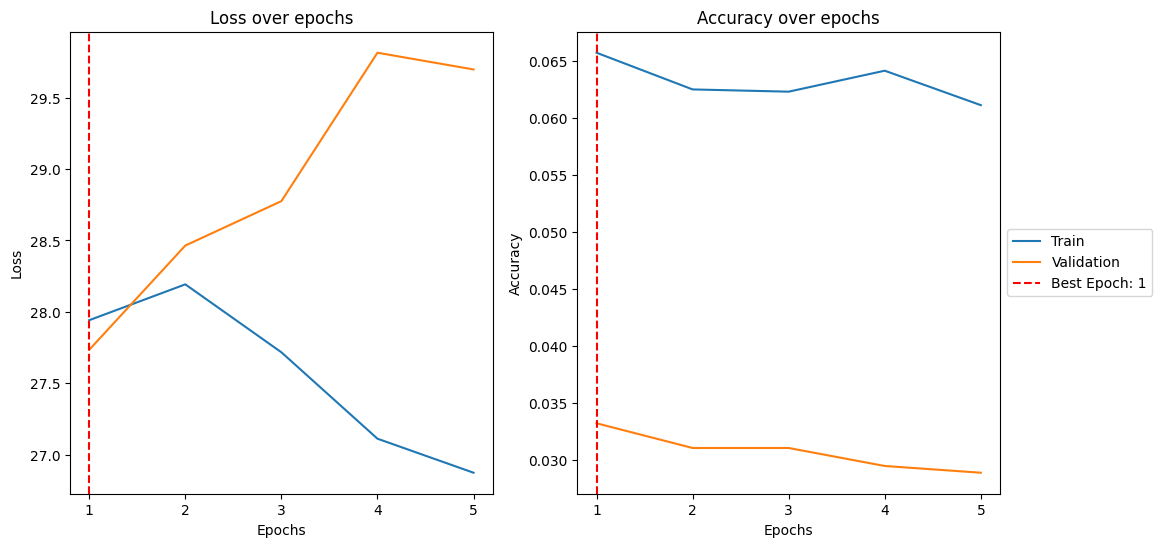


Matrix: custom_class_weights_matrix



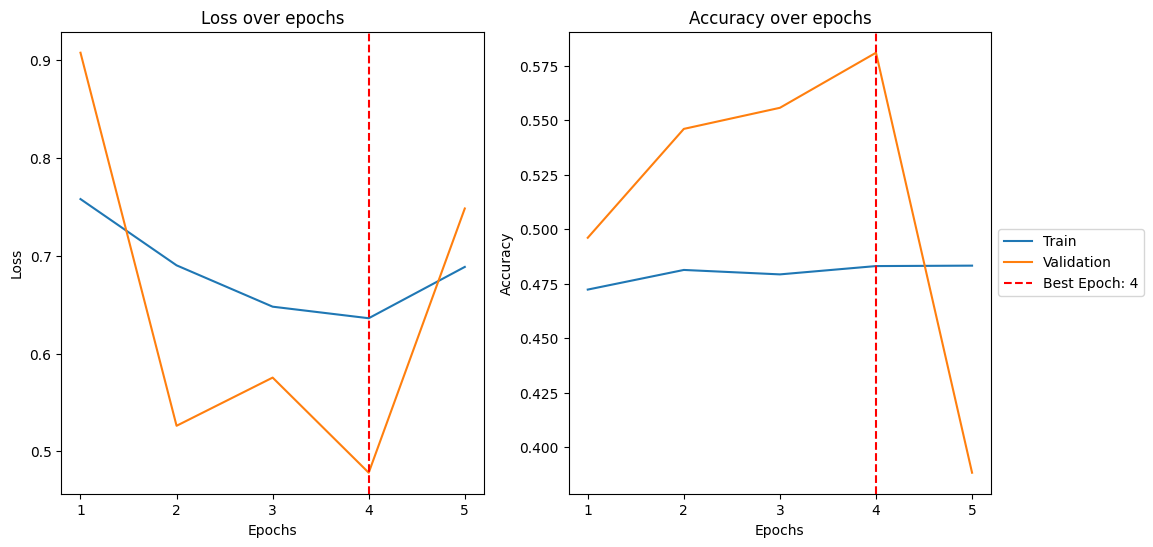

In [13]:
for index, model_ft in enumerate(models):
    print(f"Matrix: {save_dirs[index]}\n")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_epoch = 1
    
    # Load the checkpoint
    checkpoint = torch.load(os.path.join(save_dirs[index], 'checkpoint.pth.tar'))
    
    # Load model state_dict
    model_ft.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state_dict
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load scheduler state_dict
    exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # Retrieve other variables
    best_combined_metric = checkpoint['best_combined_metric']
    best_val_loss = checkpoint['best_val_loss']
    best_val_acc = checkpoint['best_val_acc']
    best_epoch = checkpoint['best_epoch']
    train_losses = checkpoint['train_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_losses = checkpoint['val_losses']
    val_accuracies = checkpoint['val_accuracies']
    
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)
    
    print()

Matrix: equal_class_weights_matrix



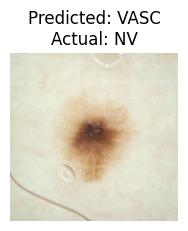

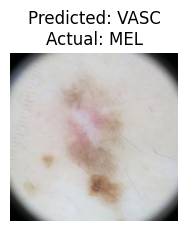

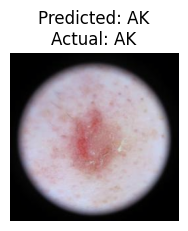

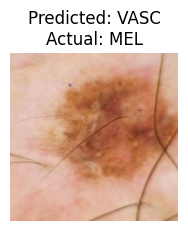


Matrix: custom_class_weights_matrix



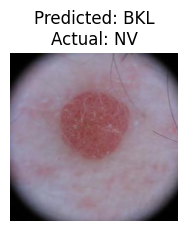

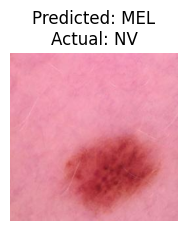

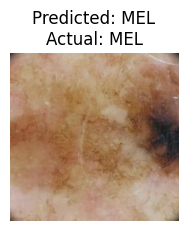

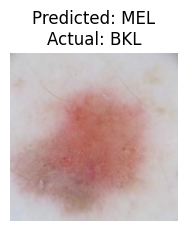

In [14]:
for index, model_ft in enumerate(models):
    print(f"Matrix: {save_dirs[index]}\n")
    
    visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)
    
    print()

In [ ]:
master_risks_list = []
master_labels_list = []

master_risks_list_by_class = []
master_labels_list_by_class = []

for index, model_ft in enumerate(models):
    print(f"Matrix: {save_dirs[index]}\n")
    
    # Lists to store results
    risks_list = []
    labels_list = []
    
    risks_list_by_class = [[] for _ in range(len(class_names))]
    labels_list_by_class = [[] for _ in range(len(class_names))]
    
    uncertainty_functions = [
        (calculate_softmax_uncertainties, "Softmax Response"),
        (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
        (calculate_random_uncertainties, "Random Uncertainties"),
        (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", {"num_samples": 10}),
        (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", {"num_samples": 10}),
        (calculate_variance_uncertainties, "Variance"),
        (calculate_variational_ratio_uncertainties, "Variational Ratio"),
        (calculate_variational_ratio_dropout_uncertainties, "Variational Ratio with Dropout", {"num_samples": 10}),
        (calculate_entropy_uncertainties, "Entropy"),
        (calculate_predictive_entropy_uncertainties, "Predictive Entropy", {"num_samples": 10}),
        (calculate_mutual_information_uncertainties, "Mutual Information"),
        (calculate_mutual_information_mc_dropout, "Mutual Information with Dropout", {"num_samples": 10})
    ]
    
    for function, name, *args in uncertainty_functions:
        if args:  # Check if additional arguments exist
            additional_args = args[0]  # Extract additional arguments
            process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, **additional_args)  # Pass additional arguments as keyword arguments
        else:
            process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name)

    master_risks_list.append(risks_list)
    master_labels_list.append(labels_list)
    
    master_risks_list_by_class.append(risks_list_by_class)
    master_labels_list_by_class.append(labels_list_by_class)
    
    print()

In [16]:
# Define the desired metrics to plot
# comment out undesired metrics
desired_metrics = [
    "Softmax Response",
    "Top2 Softmax Difference",
    "Random Uncertainties",
    "MCD By Sample",
    "MCD By Class",
    "Variance",
    "Variational Ratio",
    "Variational Ratio with Dropout",
    "Entropy",
    "Predictive Entropy",
    "Mutual Information",
    "Mutual Information with Dropout"
]

Matrix: equal_class_weights_matrix

All Classes: 5062 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.9692
Top2 Softmax Difference             	0.9694
Random Uncertainties                	0.9696
Predictive Entropy                  	0.9703
Variational Ratio with Dropout      	0.9710
MCD By Sample                       	0.9734
Softmax Response                    	0.9735
Mutual Information with Dropout     	0.9737
Entropy                             	0.9737
Mutual Information                  	0.9748
Variance                            	0.9749
MCD By Class                        	0.9759

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Random Uncertainties                	0.7731
Variational Ratio                   	0.7739
Predictive Entropy                  	0.7740
Top2 Softmax Difference             	0.7740
Variational Ratio with Dropout  

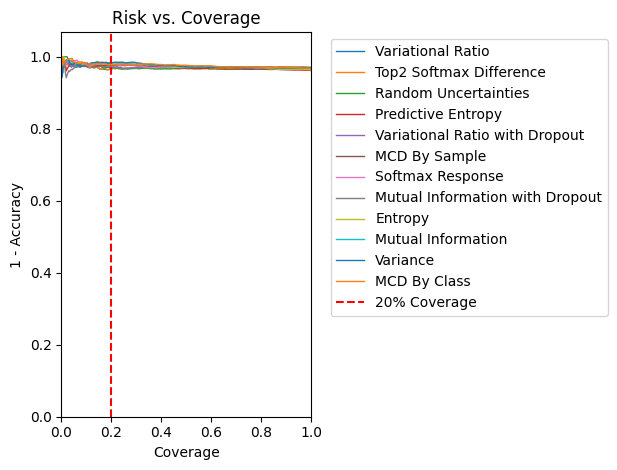


Matrix: custom_class_weights_matrix

All Classes: 5062 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio with Dropout      	0.5318
Variational Ratio                   	0.5319
Top2 Softmax Difference             	0.5439
Variance                            	0.5756
Softmax Response                    	0.5775
MCD By Sample                       	0.5782
Predictive Entropy                  	0.5797
Entropy                             	0.5850
Mutual Information with Dropout     	0.5902
Mutual Information                  	0.5976
MCD By Class                        	0.5982
Random Uncertainties                	0.6111

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.4542
Variational Ratio with Dropout      	0.4554
Top2 Softmax Difference             	0.4627
Softmax Response                    	0.4818
MCD By Sample                 

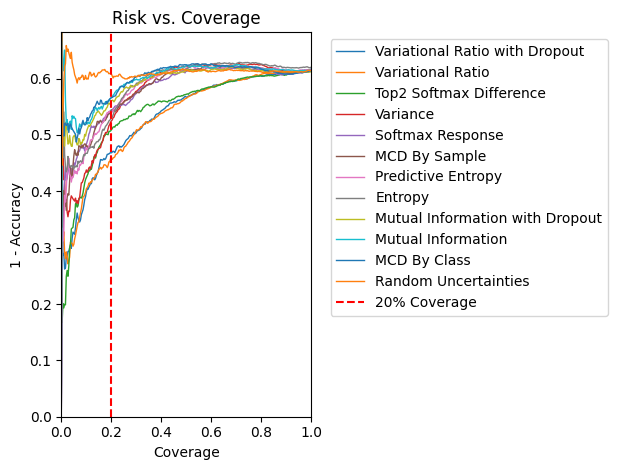

In [17]:
for index, model_ft in enumerate(models):
    print(f"Matrix: {save_dirs[index]}\n")
    # Select desired metrics for all samples
    selected_labels_list, selected_risks_list = select_desired_metrics(master_labels_list[index], master_risks_list[index], desired_metrics)
    
    # Print information about all classes
    print(f"All Classes: {len(selected_risks_list[0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list[0])
    calculate_aurc(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)
    plot_risk_coverage(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)

    print()

AK: 173 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Mutual Information                  	0.6623
Variance                            	0.6630
Mutual Information with Dropout     	0.6732
MCD By Sample                       	0.6920
Random Uncertainties                	0.6979
Softmax Response                    	0.7034
Predictive Entropy                  	0.7086
Variational Ratio with Dropout      	0.7333
Top2 Softmax Difference             	0.7399
MCD By Class                        	0.7407
Variational Ratio                   	0.7435
Entropy                             	0.7725

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Mutual Information                  	0.5474
Variance                            	0.5495
Mutual Information with Dropout     	0.5502
Random Uncertainties                	0.5583
Softmax Response                    	0.5705
MCD By Sample                     

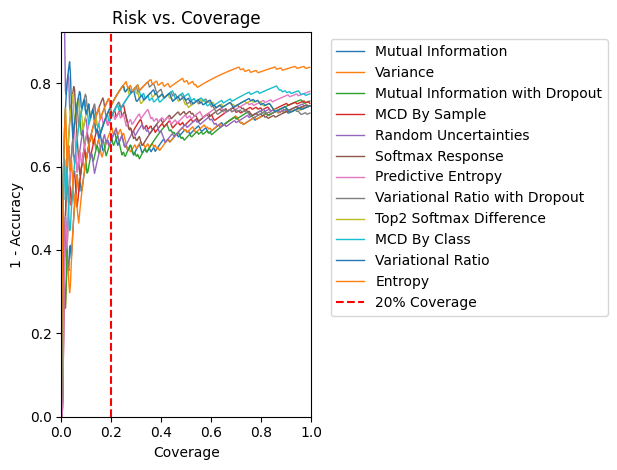


BCC: 664 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Entropy                             	0.9855
Predictive Entropy                  	0.9934
Mutual Information with Dropout     	0.9951
Variational Ratio                   	0.9962
Top2 Softmax Difference             	0.9962
MCD By Sample                       	0.9968
Softmax Response                    	0.9971
Random Uncertainties                	0.9971
Variance                            	0.9979
Mutual Information                  	0.9980
Variational Ratio with Dropout      	0.9984
MCD By Class                        	0.9985

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Entropy                             	0.7853
Predictive Entropy                  	0.7931
Mutual Information with Dropout     	0.7947
Variational Ratio                   	0.7958
Top2 Softmax Difference             	0.7959
MCD By Sample                   

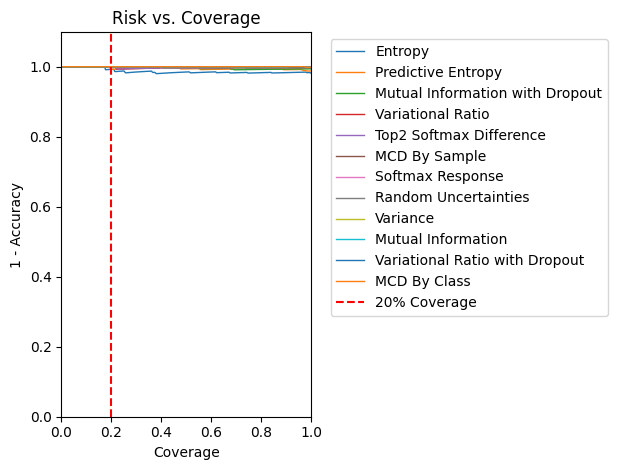


BKL: 524 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.9789
Entropy                             	0.9796
Variational Ratio with Dropout      	0.9799
Variational Ratio                   	0.9807
Top2 Softmax Difference             	0.9809
MCD By Sample                       	0.9819
Random Uncertainties                	0.9820
Mutual Information with Dropout     	0.9869
Softmax Response                    	0.9877
MCD By Class                        	0.9879
Variance                            	0.9902
Mutual Information                  	0.9903

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Entropy                             	0.7793
Predictive Entropy                  	0.7801
Variational Ratio                   	0.7821
Variational Ratio with Dropout      	0.7822
Top2 Softmax Difference             	0.7824
Random Uncertainties            

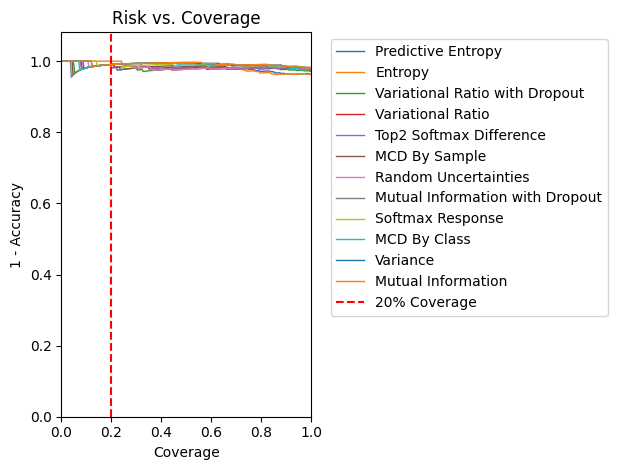


DF: 47 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Entropy                             	0.6007
Mutual Information                  	0.6524
Variance                            	0.6687
Mutual Information with Dropout     	0.6884
Softmax Response                    	0.7023
Variational Ratio with Dropout      	0.7055
Predictive Entropy                  	0.7351
MCD By Class                        	0.7759
Top2 Softmax Difference             	0.7777
Variational Ratio                   	0.7789
Random Uncertainties                	0.7967
MCD By Sample                       	0.8002

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Entropy                             	0.5210
Mutual Information                  	0.5291
Variance                            	0.5347
Softmax Response                    	0.5543
Mutual Information with Dropout     	0.5582
Variational Ratio with Dropout    

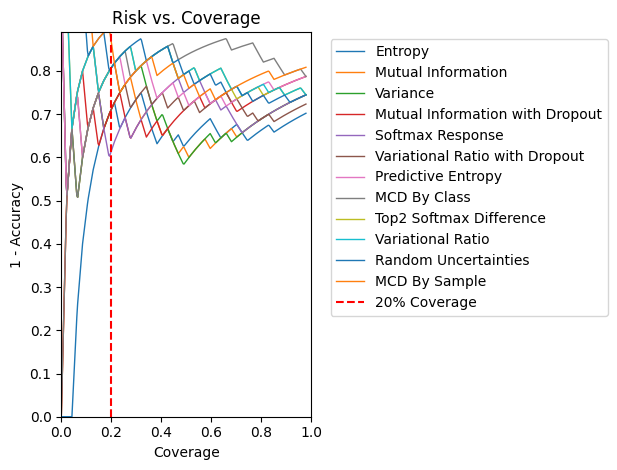


MEL: 904 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.9875
Entropy                             	0.9932
MCD By Sample                       	0.9987
Variational Ratio                   	0.9988
Top2 Softmax Difference             	0.9988
Random Uncertainties                	0.9988
Variance                            	0.9989
Mutual Information                  	0.9989
Softmax Response                    	0.9989
MCD By Class                        	0.9989
Variational Ratio with Dropout      	0.9989
Mutual Information with Dropout     	0.9989

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.7901
Entropy                             	0.7928
MCD By Sample                       	0.7982
Variational Ratio                   	0.7983
Top2 Softmax Difference             	0.7983
Random Uncertainties            

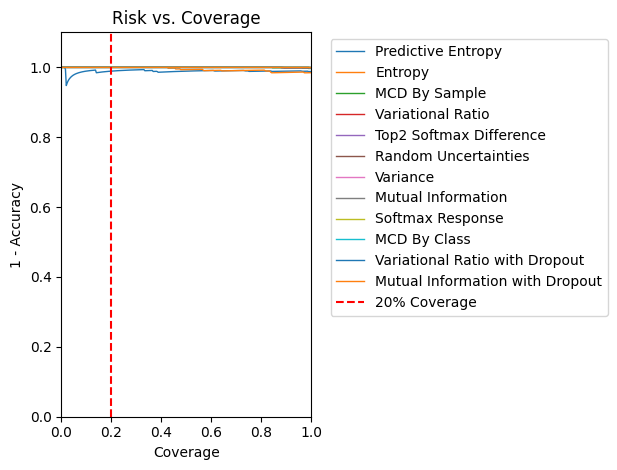


NV: 2575 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.9904
Entropy                             	0.9924
Mutual Information with Dropout     	0.9934
Random Uncertainties                	0.9941
Variational Ratio with Dropout      	0.9950
MCD By Class                        	0.9950
Variational Ratio                   	0.9959
Top2 Softmax Difference             	0.9960
Mutual Information                  	0.9970
Variance                            	0.9971
Softmax Response                    	0.9974
MCD By Sample                       	0.9983

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.7901
Entropy                             	0.7922
Random Uncertainties                	0.7936
Mutual Information with Dropout     	0.7943
Variational Ratio with Dropout      	0.7945
MCD By Class                    

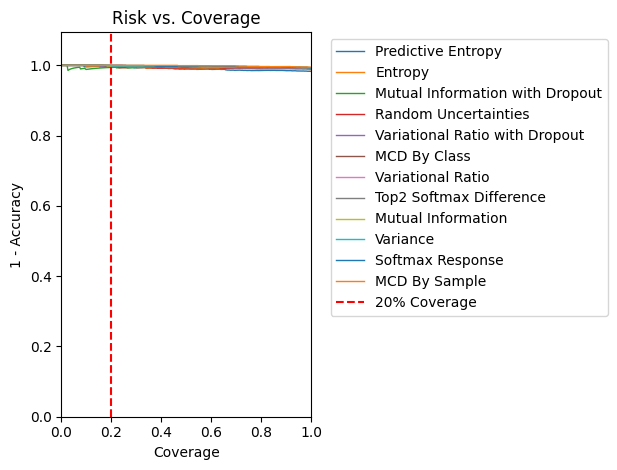


SCC: 125 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.4943
Top2 Softmax Difference             	0.4950
Softmax Response                    	0.5001
MCD By Sample                       	0.5145
Variational Ratio with Dropout      	0.5232
Random Uncertainties                	0.5327
Variance                            	0.5512
Mutual Information                  	0.5563
MCD By Class                        	0.5805
Mutual Information with Dropout     	0.6094
Entropy                             	0.6582
Predictive Entropy                  	0.7043

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.3883
Top2 Softmax Difference             	0.3886
Softmax Response                    	0.3887
Variational Ratio with Dropout      	0.4125
MCD By Sample                       	0.4173
Variance                        

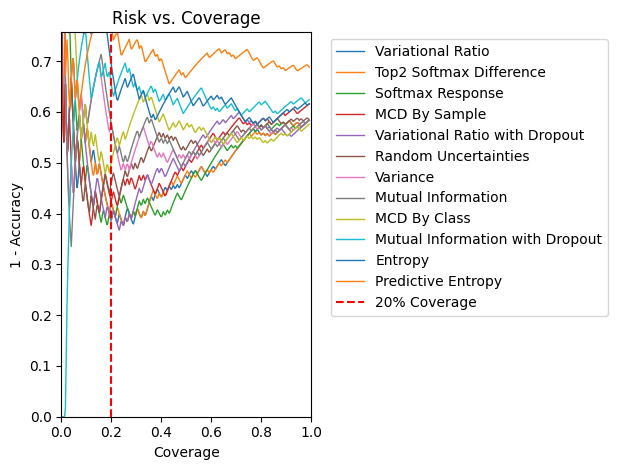


VASC: 50 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.4530
Random Uncertainties                	0.5834
Variational Ratio                   	0.6404
Top2 Softmax Difference             	0.6427
MCD By Class                        	0.6827
Variational Ratio with Dropout      	0.6935
MCD By Sample                       	0.7023
Softmax Response                    	0.7334
Mutual Information with Dropout     	0.7553
Mutual Information                  	0.7632
Entropy                             	0.7739
Variance                            	0.7772

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.3867
Random Uncertainties                	0.4399
Variational Ratio                   	0.4691
Top2 Softmax Difference             	0.4713
MCD By Class                        	0.5008
Variational Ratio with Dropout  

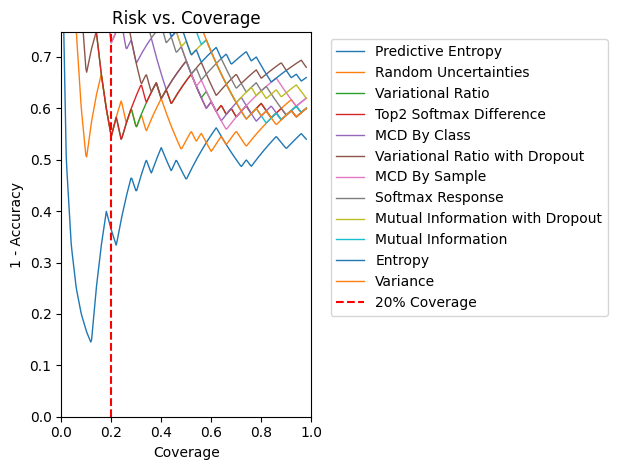


AK: 173 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.9813
Entropy                             	0.9912
Softmax Response                    	0.9942
Top2 Softmax Difference             	0.9942
Random Uncertainties                	0.9942
MCD By Sample                       	0.9942
MCD By Class                        	0.9942
Variance                            	0.9942
Variational Ratio                   	0.9942
Variational Ratio with Dropout      	0.9942
Mutual Information                  	0.9942
Mutual Information with Dropout     	0.9942

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.7805
Entropy                             	0.7884
Softmax Response                    	0.7914
Top2 Softmax Difference             	0.7914
Random Uncertainties                	0.7914
MCD By Sample                    

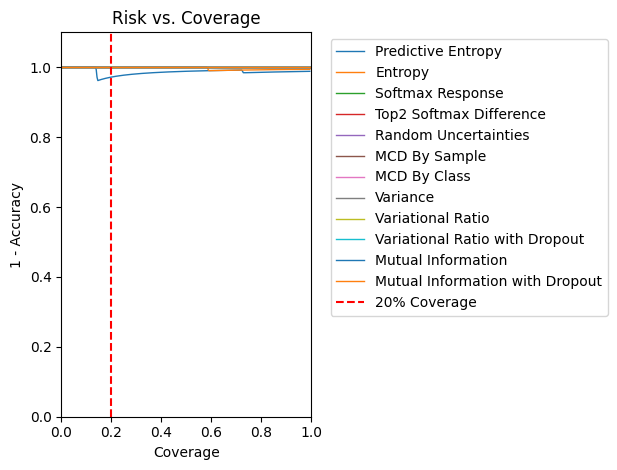


BCC: 664 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.1586
Variational Ratio with Dropout      	0.1598
Top2 Softmax Difference             	0.1987
Random Uncertainties                	0.3880
Softmax Response                    	0.4744
MCD By Sample                       	0.4829
MCD By Class                        	0.5055
Mutual Information with Dropout     	0.5098
Mutual Information                  	0.5228
Variance                            	0.5716
Entropy                             	0.5826
Predictive Entropy                  	0.5830

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.1573
Variational Ratio with Dropout      	0.1581
Top2 Softmax Difference             	0.1877
Random Uncertainties                	0.3122
Softmax Response                    	0.3422
MCD By Sample                   

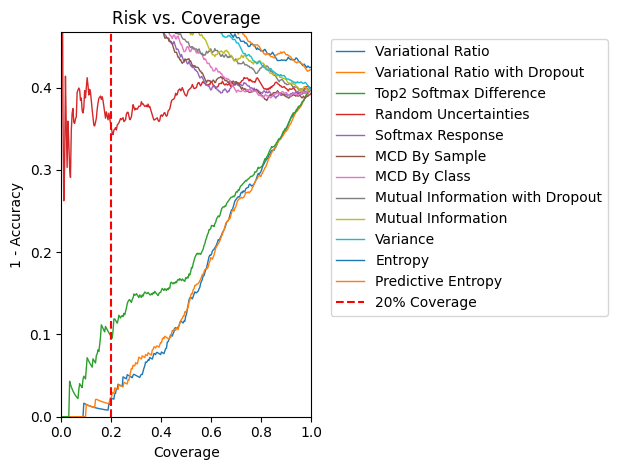


BKL: 524 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Random Uncertainties                	0.8553
Mutual Information                  	0.8869
Mutual Information with Dropout     	0.8877
Entropy                             	0.9071
MCD By Class                        	0.9107
Predictive Entropy                  	0.9216
MCD By Sample                       	0.9289
Variational Ratio with Dropout      	0.9319
Variational Ratio                   	0.9322
Variance                            	0.9339
Softmax Response                    	0.9345
Top2 Softmax Difference             	0.9395

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Random Uncertainties                	0.6799
Mutual Information                  	0.7076
Entropy                             	0.7089
Mutual Information with Dropout     	0.7110
MCD By Class                        	0.7143
Predictive Entropy              

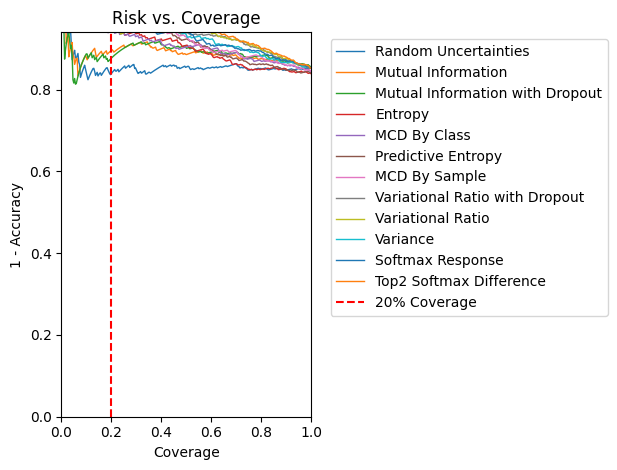


DF: 47 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.9787
Top2 Softmax Difference             	0.9787
Random Uncertainties                	0.9787
MCD By Sample                       	0.9787
MCD By Class                        	0.9787
Variance                            	0.9787
Variational Ratio                   	0.9787
Variational Ratio with Dropout      	0.9787
Entropy                             	0.9787
Predictive Entropy                  	0.9787
Mutual Information                  	0.9787
Mutual Information with Dropout     	0.9787

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.7758
Top2 Softmax Difference             	0.7758
Random Uncertainties                	0.7758
MCD By Sample                       	0.7758
MCD By Class                        	0.7758
Variance                          

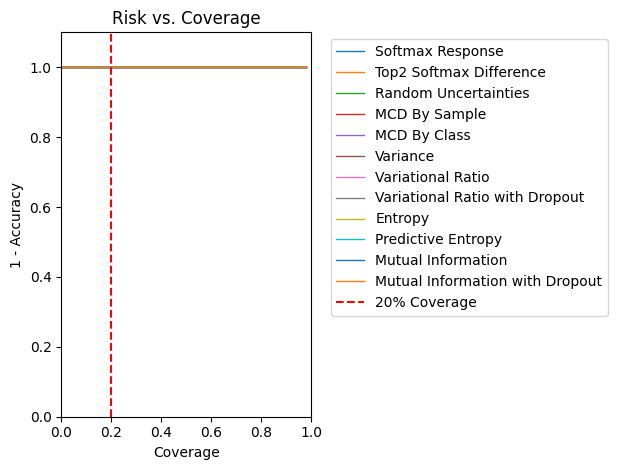


MEL: 904 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Top2 Softmax Difference             	0.0117
Variational Ratio                   	0.0188
Variational Ratio with Dropout      	0.0208
Softmax Response                    	0.0212
MCD By Sample                       	0.0243
Predictive Entropy                  	0.0252
MCD By Class                        	0.0256
Variance                            	0.0318
Mutual Information                  	0.0377
Mutual Information with Dropout     	0.0382
Entropy                             	0.0574
Random Uncertainties                	0.0660

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Top2 Softmax Difference             	0.0117
Variational Ratio                   	0.0177
Variational Ratio with Dropout      	0.0194
Predictive Entropy                  	0.0209
Softmax Response                    	0.0211
MCD By Class                    

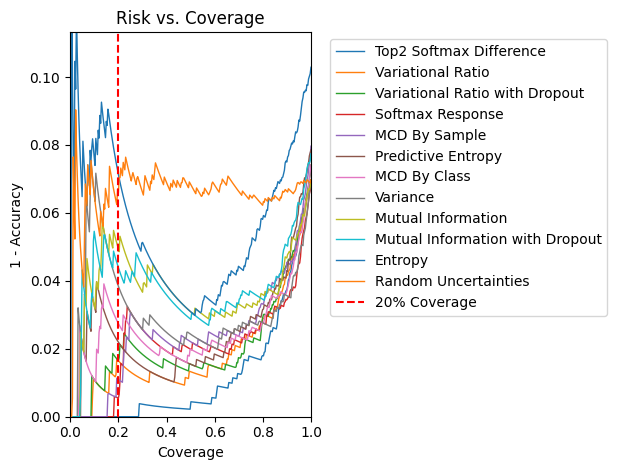


NV: 2575 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variance                            	0.6005
Predictive Entropy                  	0.6119
Entropy                             	0.6148
MCD By Sample                       	0.6461
Softmax Response                    	0.6481
Mutual Information with Dropout     	0.6493
Mutual Information                  	0.6611
MCD By Class                        	0.6636
Random Uncertainties                	0.7356
Top2 Softmax Difference             	0.7973
Variational Ratio with Dropout      	0.8323
Variational Ratio                   	0.8339

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Variance                            	0.5144
Entropy                             	0.5221
Predictive Entropy                  	0.5227
Softmax Response                    	0.5409
MCD By Sample                       	0.5414
Mutual Information with Dropout 

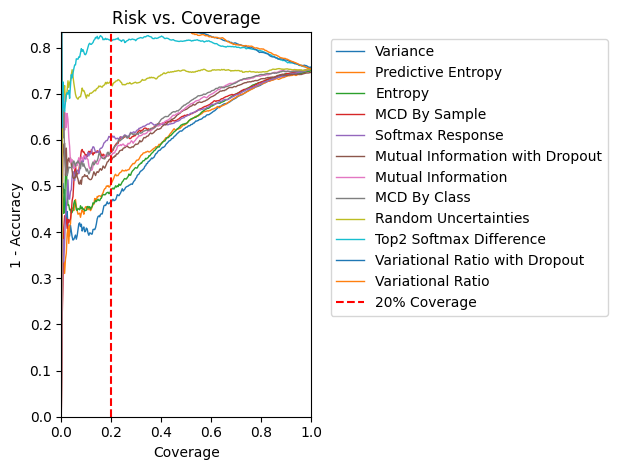


SCC: 125 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.9920
Top2 Softmax Difference             	0.9920
Random Uncertainties                	0.9920
MCD By Sample                       	0.9920
MCD By Class                        	0.9920
Variance                            	0.9920
Variational Ratio                   	0.9920
Variational Ratio with Dropout      	0.9920
Entropy                             	0.9920
Predictive Entropy                  	0.9920
Mutual Information                  	0.9920
Mutual Information with Dropout     	0.9920

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.7896
Top2 Softmax Difference             	0.7896
Random Uncertainties                	0.7896
MCD By Sample                       	0.7896
MCD By Class                        	0.7896
Variance                        

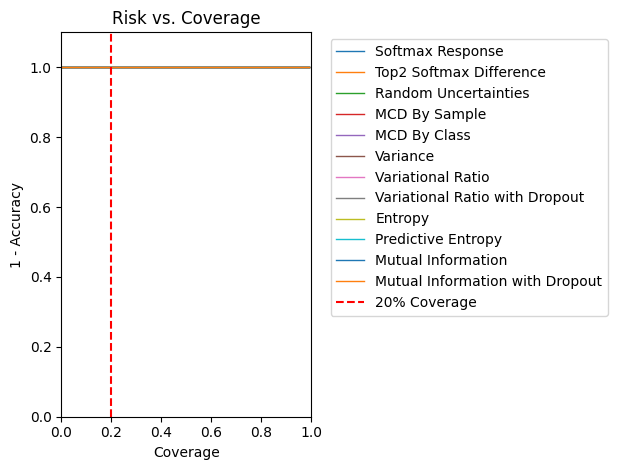


VASC: 50 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Entropy                             	0.9708
Softmax Response                    	0.9800
Top2 Softmax Difference             	0.9800
Random Uncertainties                	0.9800
MCD By Sample                       	0.9800
MCD By Class                        	0.9800
Variance                            	0.9800
Variational Ratio                   	0.9800
Variational Ratio with Dropout      	0.9800
Predictive Entropy                  	0.9800
Mutual Information                  	0.9800
Mutual Information with Dropout     	0.9800

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Entropy                             	0.7676
Softmax Response                    	0.7768
Top2 Softmax Difference             	0.7768
Random Uncertainties                	0.7768
MCD By Sample                       	0.7768
MCD By Class                    

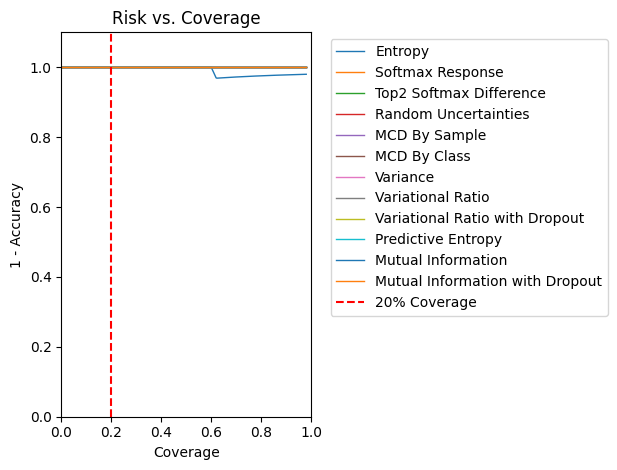

In [18]:
for index, model_ft in enumerate(models):
    # Iterate over each class
    for i in range(len(class_names)):
        # Select desired metrics for the current class
        selected_labels_list_class, selected_risks_list_class = select_desired_metrics(master_labels_list_by_class[index][i], master_risks_list_by_class[index][i], desired_metrics)
        
        # Print information about the current class
        print(f"{class_names[i]}: {len(selected_risks_list_class[0])} samples")
        x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list_class[0])
        calculate_aurc(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
        plot_risk_coverage(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
        print()

OLD STUFF BELOW

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_epoch = 1

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.4)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Convert targets to tensor and move to device
targets_tensor = torch.tensor(image_datasets['train'].targets).to(device)

# Compute class weights
class_weights = compute_class_weights(targets_tensor, len(image_datasets['train'].classes))

# Print class weights
print("Class Weights:", class_weights)

In [ ]:
# Define the class weights matrices and move to device
equal_class_weights_matrix = torch.tensor([
    [0, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 0]
], dtype=torch.float).to(device)

custom_class_weights_matrix = torch.tensor([
    [0,  1,  20,  20,  10, 20,  10, 1],
    [1,  0,  30,  30,  10, 30,  10, 1],
    [10, 10, 0,   1,   10, 1,   10, 10],
    [10, 10, 1,   0,   10, 1,   10, 10],
    [10, 10, 150, 150, 0,  150, 1,  10],
    [10, 10, 1,   1,   10, 0,   10, 10],
    [10, 10, 150, 150, 1,  150, 0,  10],
    [1,  1,  20,  20,  10, 20,  10, 0]
], dtype=torch.float).to(device)

equal_class_weights_matrix = normalize_matrix(equal_class_weights_matrix)
custom_class_weights_matrix = normalize_matrix(custom_class_weights_matrix)

# Print the normalized matrices
print_matrix("Equal Cost Matrix", equal_class_weights_matrix)
print_matrix("Custom Cost Matrix", custom_class_weights_matrix)

In [ ]:
# Balance the custom class weights matrix using the calculated class weights
balanced_class_weights_matrix = custom_class_weights_matrix * torch.tensor(class_weights, dtype=torch.float).unsqueeze(0).to(device) * 7

print_matrix("Balanced Class Weights Matrix", balanced_class_weights_matrix)

In [ ]:
# Define the loss function using the custom loss
criterion = CustomLoss(balanced_class_weights_matrix).to(device)

In [ ]:
model_ft = model_ft.to(device)

In [ ]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=25, num_val_mc_samples=100, loss_weight=1, acc_weight=0, num_classes=num_classes, save_dir="custom_weights_matrix", resume_training=False)

In [ ]:
# Load the checkpoint
checkpoint = torch.load('test/checkpoint.pth.tar')

# Load model state_dict
model_ft.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state_dict
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

# Load scheduler state_dict
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Retrieve other variables
best_combined_metric = checkpoint['best_combined_metric']
best_val_loss = checkpoint['best_val_loss']
best_val_acc = checkpoint['best_val_acc']
best_epoch = checkpoint['best_epoch']
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

In [ ]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

In [ ]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [ ]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

uncertainty_functions = [
    (calculate_softmax_uncertainties, "Softmax Response"),
    (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
    (calculate_random_uncertainties, "Random Uncertainties"),
    (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", {"num_samples": 1}),
    (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", {"num_samples": 1}),
    (calculate_variance_uncertainties, "Variance"),
    (calculate_variational_ratio_uncertainties, "Variational Ratio"),
    (calculate_variational_ratio_dropout_uncertainties, "Variational Ratio with Dropout", {"num_samples": 1}),
    (calculate_entropy_uncertainties, "Entropy"),
    (calculate_predictive_entropy_uncertainties, "Predictive Entropy", {"num_samples": 1}),
    (calculate_mutual_information_uncertainties, "Mutual Information"),
    (calculate_mutual_information_mc_dropout, "Mutual Information with Dropout", {"num_samples": 1})
]

for function, name, *args in uncertainty_functions:
    if args:  # Check if additional arguments exist
        additional_args = args[0]  # Extract additional arguments
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, **additional_args)  # Pass additional arguments as keyword arguments
    else:
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name)

print("Done")

In [ ]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)

In [ ]:
# Define the desired metrics to plot
# comment out undesired metrics
desired_metrics = [
    "Softmax Response",
    "Top2 Softmax Difference",
    "Random Uncertainties",
    "MCD By Sample",
    "MCD By Class",
    "Variance",
    "Variational Ratio",
    "Variational Ratio with Dropout",
    "Entropy",
    "Predictive Entropy",
    "Mutual Information",
    "Mutual Information with Dropout"
]

# Select desired metrics for all samples
selected_labels_list, selected_risks_list = select_desired_metrics(labels_list, risks_list, desired_metrics)

# Print information about all classes
print(f"All Classes: {len(selected_risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list[0])
calculate_aurc(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)
plot_risk_coverage(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)

# Iterate over each class
for i in range(len(class_names)):
    # Select desired metrics for the current class
    selected_labels_list_class, selected_risks_list_class = select_desired_metrics(labels_list_by_class[i], risks_list_by_class[i], desired_metrics)
    
    # Print information about the current class
    print(f"{class_names[i]}: {len(selected_risks_list_class[0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list_class[0])
    calculate_aurc(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    plot_risk_coverage(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    print()

print("done")